**Problem**: Given a phishing url, classify the domain as compromised (owned) or malicious (hacked).

**Objective**: Given labeled data, analyze the best model and features.

In [1]:
import sklearn
print(sklearn.__version__)

0.19.1


# Setup

In [163]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression

#from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#import xgboost as xgb

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# orange
from Orange.classification.rules import CN2Learner
from Orange.evaluation import compute_CD, graph_ranks

# scipy
import scipy
from scipy.stats import friedmanchisquare
from scipy.stats import rankdata

from pprint import pprint

import pickle

import numpy as np
from numpy import nan

import random

# Data

In [372]:
# balanced train and test sets
def balance_data(X, y):
    X_bal = []
    y_bal = []
    X_rest = []
    y_rest = []
    min1 = len([tar for tar in y if tar==1])
    min2 = len([tar for tar in y if tar==-1])
    mini = min1
    if min2 < min1:
        mini = min2

    cnt_1 = 0
    cnt_0 = 0
    print(mini)
    for i, tar in enumerate(y):
        if tar == 1 and cnt_1<mini:
            cnt_1+=1
            X_bal.append(X[i])
            y_bal.append(y[i])
        elif tar == -1 and cnt_0<mini:
            cnt_0+=1
            X_bal.append(X[i])
            y_bal.append(y[i])
        else:
            X_rest.append(X[i])
            y_rest.append(y[i])

    print("# X_bal:", len(X_bal))
    print("# y_bal:", len(y_bal))
    print("% compromised: ", len([tar for tar in y_bal if tar==1])/len(y_bal))
    print("% malicious: ", len([tar for tar in y_bal if tar==-1])/len(y_bal))
    
    print("# X_rest:", len(X_rest))
    print("# y_rest:", len(y_rest))
    print("% compromised: ", len([tar for tar in y_rest if tar==1])/len(y_rest))
    print("% malicious: ", len([tar for tar in y_rest if tar==-1])/len(y_rest))
    
    return [X_bal, y_bal, X_rest, y_rest]

### Train/Test

In [373]:
with open("data/data_cluster_6409", "r", encoding='utf-8') as f:
    data_train = eval(f.read())
    
random.Random(4).shuffle(data_train)

Xtrain = np.array([d['feat'] for d in data_train])
ytrain = np.array([d['target'] for d in data_train])
feat_labels = data_train[0]['feat_labels']
print(Xtrain.shape)
print(ytrain.shape)
print(feat_labels)
pprint(data_train[:5])
pprint(Xtrain[:5])
pprint(ytrain[:5])
print("# compromised: ", len([tar for tar in ytrain if tar==1]))
print("# malicious: ", len([tar for tar in ytrain if tar==-1]))
print("% compromised: ", len([tar for tar in ytrain if tar==1])/len(ytrain))
print("% malicious: ", len([tar for tar in ytrain if tar==-1])/len(ytrain))

(6409, 19)
(6409,)
['archived', 'years_active', 'years_inactive', 'num_captures', 'freenom_tld', 'prev_mal_tld', 'wildcard_subdomain', 'reachable', 'redirected', 'blocked', 'alexa_rank', 'ratio_longest_word', 'contain_digit', 'contain_dash', 'name_len', 'brandname_partialratio', 'prev_mal_domain_ed', 'sub_levels', 'num_sub']
[{'dataset': 'unlabeled-apwg',
  'feat': [1,
           3,
           0,
           19.0,
           0,
           0,
           0,
           1,
           0,
           0,
           nan,
           0.2857142857142857,
           0,
           0,
           4,
           67,
           0.25,
           0,
           1],
  'feat_labels': ['archived',
                  'years_active',
                  'years_inactive',
                  'num_captures',
                  'freenom_tld',
                  'prev_mal_tld',
                  'wildcard_subdomain',
                  'reachable',
                  'redirected',
                  'blocked',
                

In [374]:
# balance
Xtrain, ytrain, Xtest, ytest = balance_data(Xtrain, ytrain)

2356
# X_bal: 4712
# y_bal: 4712
% compromised:  0.5
% malicious:  0.5
# X_rest: 1697
# y_rest: 1697
% compromised:  1.0
% malicious:  0.0


### Predict

In [375]:
with open("/home/sophie/SSRG/domainclassification/results/dataset/domain_target_55383", "r", encoding='utf-8') as f:
    data_predict = eval(f.read())
    
random.Random(4).shuffle(data_predict)
    
datasets = set([d['dataset'] for d in data_predict])
pprint(datasets)

{'comp-deltaphish',
 'comp-phishlabs',
 'mal-apwg',
 'mal-future-apwg',
 'mal-phishlabs',
 'unlabeled-apwg'}


#### Cluster training

In [376]:
#data used for cluster training
dataset_val = {"comp-phishlabs", "mal-apwg"}
#dataset_val = {"comp-deltaphish", "mal-apwg"}
Xval = np.array([d['feat'] for d in data_predict if d['dataset'] in dataset_val])
yval = np.array([d['target'] for d in data_predict if d['dataset'] in dataset_val])
feat_labels = data_predict[0]['feat_labels']
print(Xval.shape)
print(yval.shape)
print(feat_labels)
pprint(Xval[:5])
pprint(yval[:5])
print("# compromised: ", len([tar for tar in yval if tar==1]))
print("# malicious: ", len([tar for tar in yval if tar==-1]))
print("% compromised: ", len([tar for tar in yval if tar==1])/len(yval))
print("% malicious: ", len([tar for tar in yval if tar==-1])/len(yval))

(1164, 19)
(1164,)
['archived', 'years_active', 'years_inactive', 'num_captures', 'freenom_tld', 'prev_mal_tld', 'wildcard_subdomain', 'reachable', 'redirected', 'blocked', 'alexa_rank', 'ratio_longest_word', 'contain_digit', 'contain_dash', 'name_len', 'brandname_partialratio', 'prev_mal_domain_ed', 'sub_levels', 'num_sub']
array([[1.00000000e+00, 1.60000000e+01, 1.00000000e+00, 8.44000000e+02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.30597000e+05, 3.15789474e-01,
        0.00000000e+00, 0.00000000e+00, 1.50000000e+01, 6.70000000e+01,
        6.66666667e-02, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00,            nan,            nan,            nan,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 0.00000000e+00,            nan, 3.18181818e-01,
        0.00000000e+00, 0.00000000e+00, 1.80000000e+01, 1.00000000e+02,
        5.55555556e-02, 0.00000000e+00, 

In [377]:
# balance
Xvalb, yvalb, Xvaltestb, yvaltestb = balance_data(Xval, yval)

495
# X_bal: 990
# y_bal: 990
% compromised:  0.5
% malicious:  0.5
# X_rest: 174
# y_rest: 174
% compromised:  1.0
% malicious:  0.0


# Normalize and imputer

In [378]:
imp = Imputer(missing_values=np.nan, strategy='mean')
imp.fit(Xtrain)
Xtrain = imp.transform(Xtrain)

scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)

print(Xtrain[2])

[ 1.10175364e+00 -8.56914025e-02  3.83662731e-02 -2.83766469e-01
 -2.52404028e-02 -8.76037591e-01 -2.81072238e-01  6.27760177e-01
 -5.20514003e-01 -6.49935977e-01  1.93551622e-13 -1.21020732e-01
 -1.58868935e-01 -2.23407416e-01 -6.86233999e-01 -2.30436734e-01
  3.46893935e-01  9.27303174e-01 -4.76666305e-02]


In [379]:
Xvalb = imp.transform(Xvalb)
Xvalb = scaler.transform(Xvalb)
print(Xvalb[2])

[-9.08029337e-01  3.41171217e-14  1.96996182e-14  1.58027665e-14
 -2.52404028e-02 -8.76037591e-01 -2.81072238e-01 -1.59296501e+00
 -1.58924077e-14 -1.07827558e-14  1.93551622e-13 -1.21114055e+00
  6.29449678e+00 -2.23407416e-01  6.80000121e-01  3.33404830e-01
 -8.25535785e-01 -3.13313679e-01 -4.76666305e-02]


# Feature calibration

In [380]:
def sortAscendingFeature(cX, cy):
    idx_cX = np.argsort(cX)
    cX = np.array(cX)[idx_cX]
    cy = np.array(cy)[idx_cX]
    return cX, idx_cX, cy

In [381]:
def calibratedFeature(cX, cy, iso=None):
    cX, idx_cX, _ = sortAscendingFeature(cX, cy)
    #print(cX[:-20])
    
    if iso is None:
        iso = IsotonicRegression(out_of_bounds='clip')
        iso.fit(cX, cy)
        
    cX = iso.transform(cX)
    #print(cX[:-20])
    
    # sort back to original indexes
    idx_cX_sort = np.sort(idx_cX)
    cX = np.array(cX)[idx_cX_sort]
    return cX, iso

In [382]:
# calibrated features
cfeatures = {'years_active', 'years_inactive', 'num_captures', 'alexa_rank', 'sub_levels', 'num_sub'}

In [383]:
iso_functions = []
for i, feat in enumerate(feat_labels):
    if feat in cfeatures:

        cX, cy = Xtrain[:,i], ytrain
        cX, iso = calibratedFeature(cX, cy)
        
        Xtrain[:, i] = cX
        iso_functions.append(iso)

In [384]:
print(len(iso_functions))

6


In [385]:
def applyIsoFunction(X, y, iso_functions):
    cnt = 0
    for i, feat in enumerate(feat_labels):
        if feat in cfeatures:
            
            # select specific feature
            cX = X[:,i]
            
            # get transformed feature with specific iso function
            cX, _ = calibratedFeature(cX, y, iso_functions[cnt])
            cnt+=1
            
            # update calibrated feature
            X[:, i] = cX
    
    return X

In [387]:
Xvalb_new = applyIsoFunction(Xvalb, yvalb, iso_functions)

# Visualize data with t-SNE

Takes a high dimensional dataset and reduces to a low dimensional graph that retains a lot of the original information.

What t-SNE does is find a way to project data into a low dimensional space so that the clustering in the high dimensional space is preserved.

O(n^2) time and memory. 

In [128]:
def plottsne(data, ax, title=None):
    X_embedded = data[0]
    y = data[1]
    sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1],
                c=y, marker='o', alpha=.3)
    #plt.colorbar(sc)
    if title:
        ax.set_title(title)
    return sc

In [129]:
def plotsidebyside(tr, te, title1=None, title2=None):
    # display images
    fig, ax = plt.subplots(1,2)
    #fig.set_size_inches(18.5, 10.5)
    fig.set_size_inches(15, 7)
    
    if tr:
        sc_tr = plottsne(tr, ax[0], title1)
    if te:
        sc_te = plottsne(te, ax[1], title2)
    
    #plt.figure(figsize=(15, 15))
    print("blue malicious (owned), yellow compromised (hacked)")

In [211]:
Xtrain_embedded = TSNE(n_components=2, perplexity=40, verbose=0).fit_transform(Xtrain)

blue malicious (owned), yellow compromised (hacked)


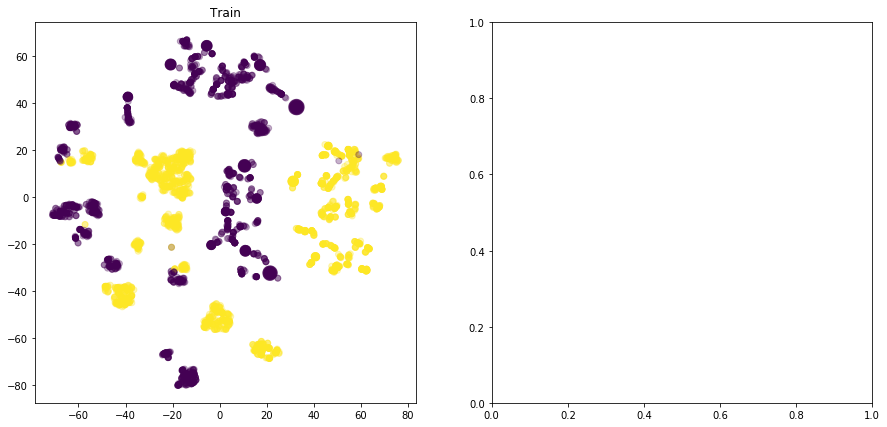

In [212]:
plotsidebyside([Xtrain_embedded, ytrain], None, title1="Train", title2="Test")

In [282]:
Xvalb_embedded = TSNE(n_components=2, perplexity=40, verbose=0).fit_transform(Xvalb_new)

blue malicious (owned), yellow compromised (hacked)


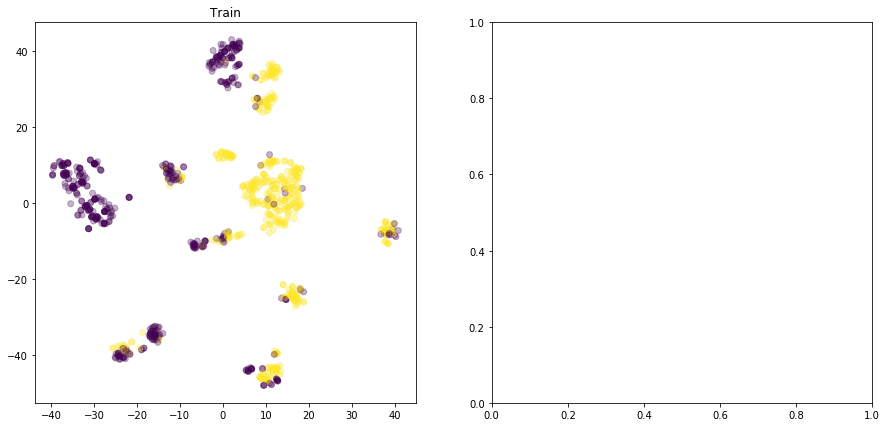

In [283]:
plotsidebyside([Xvalb_embedded, yvalb], None, title1="Train", title2="Test")

# Models

#### Default

In [388]:
names = [
         "KNeighbors", 
         #"SVM", 
         "NeuralNetwork",
         "DecisionTree", 
         #"CN2Learner",
         "RandomForest",
         "Dummy",
        ]

classifiers = [
    KNeighborsClassifier(),
    #SVC(random_state=42, probability=True),
    MLPClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    #CN2Learner(),
    #RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1, random_state=42),
    RandomForestClassifier(random_state=42),
    DummyClassifier(random_state=42),
]

#### Tunned

In [389]:
names = [
         "KNeighbors", 
         #"SVM", 
         "NeuralNetwork",
         "DecisionTree", 
         "RandomForest",
         "Dummy",
        ]

classifiers = [
    KNeighborsClassifier(n_neighbors=11, weights='uniform', p=1),
    #SVC(kernel="rbf", random_state=42, probability=True),
    MLPClassifier(random_state=42),
    DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_split=2,  max_features=2, random_state=42),
    #DecisionTreeClassifier(random_state=42),
    #RandomForestClassifier(n_estimators=100, max_depth=4, max_features='auto', random_state=42),
    RandomForestClassifier(n_estimators=100, max_depth=1, max_features='auto', random_state=42),
    #RandomForestClassifier(n_estimators=100, max_depth=5, max_features=1, random_state=42),
    DummyClassifier(random_state=42),
]

# ROC
Compare the performance of each model.

In [148]:
def plot_roc_curve(fpr, tpr, ax, axins, name, label=None):
    #plt.xlim(0, 0.2)
    #plt.ylim(0.6, 1)
    #ax.plot(fpr, tpr, 'r', linewidth=2, label=label)
    ax.plot(fpr, tpr, linewidth=2, label=label)
    ax.grid()
    if axins and name == 'Random Forest':
        axins.plot(fpr, tpr, 'r', linewidth=2)
        axins.grid()
        axins.set_xticks(ticks=[0,5,10,15,20])
        axins.set_yticks(ticks=[60,70,80,90,100])

In [149]:
def getRoc(data, title=None):
    X, y = data
    y = y
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    axins = inset_axes(ax, width=2, height=1.5, loc=10)
    #axins = inset_axes(ax)

    #plt.figure(figsize=(8, 6))
    #ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False Postive Rate (%)')
    ax.set_ylabel('True Positive Rate (%)')
    ax.axis([0, 100, 0, 100])
    ax.set_xticks(ticks=[0,10,20,30,40,50,60,70,80,90,100])
    ax.set_yticks(ticks=[0,10,20,30,40,50,60,70,80,90,100])
    
    #axins.set_xlim([0, 0.5])
    #axins.set_ylim([0.6, 1])
    axins.axis([0, 20, 60, 100])
    #plt.axis([0, 1, 0, 1])
    #plt.xlabel('False Positive Rate', fontsize=16)
    #plt.ylabel('True Positive Rate', fontsize=16)

    for name, clf in zip(names, classifiers):
        y_scores = cross_val_predict(clf, X, y, cv=10, method="predict_proba")
        fpr, tpr, thresholds = roc_curve(y, y_scores[:, 1])
        fpr, tpr = fpr*100, tpr*100
        roc_auc = auc(fpr, tpr)/(100*100)
        plot_roc_curve(fpr, tpr, ax, axins, name, label='%s (AUC = %0.3f)' % (name, roc_auc))
        clf.fit(X,y)
        
        # second validation
        predicted_proba = clf.predict_proba(Xval)
        fpr, tpr, thresholds = roc_curve(yval, predicted_proba[:, 1])
        fpr, tpr = fpr*100, tpr*100
        roc_auc = auc(fpr, tpr)/(100*100)
        print(name)
        print(roc_auc)
        

    ax.legend()
    #plt.show()

KNeighbors
0.8757621053585178
SVM
0.9032522534764686
DecisionTree
0.8338587670426234
RandomForest
0.9245157101659345
Dummy
0.5132219051501563


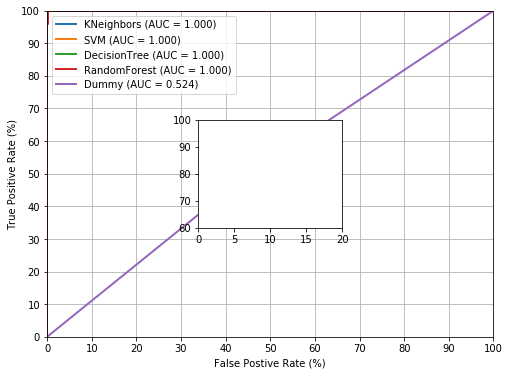

In [150]:
getRoc([Xtrain, ytrain])

In [151]:
clf = classifiers[1]
name = names[1]
model = clf.fit(Xtrain, ytrain)

#threshold = 0.67
threshold = 0.5
#threshold = 0.33

predicted = model.predict(Xtest)

tn, fp, fn, tp = confusion_matrix(ytest, predicted, labels=[-1,1]).ravel()
print(np.array([[tp, fp],[fn, tn]]))
print("acc: ", accuracy_score(ytest, predicted))
print("tpr: ", tp/(tp+fn))
print("fpr: ", fp/(tn+fp))
#print("f1: ", f1_score(ytrain, predicted, average='micro'))
print("f1: ", f1_score(ytest, predicted))

[[1862    0]
 [   0    0]]
acc:  1.0
tpr:  1.0
fpr:  nan
f1:  1.0


# Model tuning

In [297]:
def trainvalModel(clf):
    #clf = CalibratedClassifierCV(clf, cv=10, method='isotonic')
    clf.fit(Xtrain, ytrain)

    ytrain_pred = clf.predict(Xtrain)
    acc_train = accuracy_score(ytrain, ytrain_pred)
    #tn, fp, fn, tp = confusion_matrix(ytrain, ytrain_pred, labels=[-1,1]).ravel()
    #tnr_train = tn/(tn+fp)

    yval_pred = clf.predict(Xvalb_new)
    acc_val = accuracy_score(yvalb, yval_pred)
    #tn, fp, fn, tp = confusion_matrix(yvalb, yval_pred, labels=[-1,1]).ravel()
    #tnr_val = tn/(tn+fp)
    
    return acc_train, acc_val

In [298]:
def tuneModel(name, hyperparams):
    res = []
    if name == "KNeighbors":
        for n_n in hyperparams['n_neighbors']:
            for w in hyperparams['weights']:
                for pnum in hyperparams['p']:
                    clf = KNeighborsClassifier(n_neighbors=n_n, weights=w, p=pnum)
                    
                    acc_train, acc_val = trainvalModel(clf)
                    entry = [n_n, w, pnum, acc_train, acc_val]
                    
                    #print(entry)
                    res.append(entry)
                    
    elif name == "SVM":
        #for g in hyperparams['gamma']:
        for k in hyperparams['kernel']:
            for sh in hyperparams['shrinking']:
                #for d in hyperparams['degree']:
                clf = SVC(kernel=k, shrinking=sh, random_state=42)

                acc_train, acc_val = trainvalModel(clf)
                entry = [k, sh, acc_train, acc_val]

                #print(entry)
                res.append(entry)

    elif name == "DecisionTree":
        for c in hyperparams['criterion']:
            #for sp in hyperparams['splitter']:
            for md in hyperparams['max_depth']:
                for ms in hyperparams['min_samples_split']:
                    #for ml in hyperparams['min_samples_leaf']:
                    for mf in hyperparams['max_features']:
                        clf = DecisionTreeClassifier(criterion=c, max_depth=md, min_samples_split=ms, max_features=mf, random_state=42)

                        acc_train, acc_val = trainvalModel(clf)
                        entry = [c, md, ms, mf, acc_train, acc_val]

                        #print(entry)
                        res.append(entry)

    elif name == "RandomForest":
        #for c in hyperparams['criterion']:
        for ne in hyperparams['n_estimators']:
            for md in hyperparams['max_depth']:
                #for ms in hyperparams['min_samples_split']:
                    #for ml in hyperparams['min_samples_leaf']:
                for mf in hyperparams['max_features']:
                    clf = RandomForestClassifier(n_estimators=ne, max_depth=md, max_features=mf, random_state=42)

                    acc_train, acc_val = trainvalModel(clf)
                    entry = [ne, md, mf, acc_train, acc_val]

                    #print(entry)
                    res.append(entry)
    
    return res

#### KNeighbors

In [299]:
hyperparams = dict()
hyperparams['n_neighbors'] = list(range(5,15))
hyperparams['weights'] = ['uniform', 'distance']
hyperparams['p'] = [1, 2]
name = "KNeighbors"
res = tuneModel(name, hyperparams)

In [300]:
res_sorted = sorted(res, key=lambda x: x[-1], reverse=True)

In [301]:
pprint(res_sorted[:5])

[[11, 'uniform', 1, 0.9985144312393888, 0.8282828282828283],
 [9, 'uniform', 1, 0.9989388794567062, 0.8242424242424242],
 [12, 'uniform', 1, 0.9985144312393888, 0.8242424242424242],
 [11, 'distance', 1, 1.0, 0.8232323232323232],
 [12, 'distance', 1, 1.0, 0.8232323232323232]]


#### SVM

In [302]:
hyperparams = dict()
hyperparams['kernel'] = ['linear', 'rbf', 'sigmoid']
hyperparams['shrinking'] = [True, False]
#hyperparams['degree'] = list(range(1,10))
name = "SVM"
res = tuneModel(name, hyperparams)

In [303]:
res_sorted = sorted(res, key=lambda x: x[-1], reverse=True)

In [304]:
pprint(res_sorted[:20])

[['linear', True, 1.0, 0.8363636363636363],
 ['linear', False, 1.0, 0.8363636363636363],
 ['rbf', True, 1.0, 0.793939393939394],
 ['rbf', False, 1.0, 0.793939393939394],
 ['sigmoid', True, 0.9796264855687606, 0.7565656565656566],
 ['sigmoid', False, 0.9796264855687606, 0.7565656565656566]]


#### Decision Tree

In [305]:
hyperparams = dict()
hyperparams['criterion'] = ['gini', 'entropy']
#hyperparams['splitter'] = ['best', 'random']
hyperparams['max_depth'] = [None] + list(range(1,10))
hyperparams['min_samples_split'] = list(range(2,5))
#hyperparams['min_samples_leaf'] = list(range(1,10))
hyperparams['max_features'] = [None, "auto", "sqrt", "log2"] + list(range(1,10))
name = "DecisionTree"
res = tuneModel(name, hyperparams)

In [306]:
res_sorted = sorted(res, key=lambda x: x[-1], reverse=True)

In [307]:
pprint(res_sorted[:1000])

[['gini', 4, 2, 2, 0.9393039049235993, 0.8484848484848485],
 ['gini', 4, 3, 2, 0.9393039049235993, 0.8484848484848485],
 ['gini', 4, 4, 2, 0.9393039049235993, 0.8484848484848485],
 ['gini', None, 2, 8, 1.0, 0.8404040404040404],
 ['gini', None, 3, 8, 1.0, 0.8404040404040404],
 ['gini', None, 4, 8, 1.0, 0.8404040404040404],
 ['gini', 4, 2, 8, 0.995118845500849, 0.8404040404040404],
 ['gini', 4, 3, 8, 0.995118845500849, 0.8404040404040404],
 ['gini', 4, 4, 8, 0.995118845500849, 0.8404040404040404],
 ['gini', 5, 2, 8, 1.0, 0.8404040404040404],
 ['gini', 5, 3, 8, 1.0, 0.8404040404040404],
 ['gini', 5, 4, 8, 1.0, 0.8404040404040404],
 ['gini', 6, 2, 8, 1.0, 0.8404040404040404],
 ['gini', 6, 3, 8, 1.0, 0.8404040404040404],
 ['gini', 6, 4, 8, 1.0, 0.8404040404040404],
 ['gini', 7, 2, 8, 1.0, 0.8404040404040404],
 ['gini', 7, 3, 8, 1.0, 0.8404040404040404],
 ['gini', 7, 4, 8, 1.0, 0.8404040404040404],
 ['gini', 8, 2, 8, 1.0, 0.8404040404040404],
 ['gini', 8, 3, 8, 1.0, 0.8404040404040404],
 ['g

#### RandomForest

In [18]:
#RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1, random_state=42),

In [308]:
hyperparams = dict()
#hyperparams['criterion'] = ['mse', 'mae']
hyperparams['n_estimators'] = [10, 50, 100]
hyperparams['max_depth'] = [None] + list(range(1,10))
#hyperparams['min_samples_split'] = list(range(2,6))
#hyperparams['min_samples_leaf'] = list(range(1,10))
hyperparams['max_features'] = [None, "auto", "sqrt", "log2"] + list(range(1,5))
name = "RandomForest"
res = tuneModel(name, hyperparams)

In [311]:
res_sorted = sorted(res, key=lambda x: x[-1], reverse=True)

In [312]:
pprint(res_sorted[:20])

[[50, 3, 'auto', 0.9993633276740238, 0.8595959595959596],
 [50, 3, 'sqrt', 0.9993633276740238, 0.8595959595959596],
 [50, 3, 'log2', 0.9993633276740238, 0.8595959595959596],
 [50, 3, 4, 0.9993633276740238, 0.8595959595959596],
 [100, 1, 'auto', 0.9724108658743633, 0.8595959595959596],
 [100, 1, 'sqrt', 0.9724108658743633, 0.8595959595959596],
 [100, 1, 'log2', 0.9724108658743633, 0.8595959595959596],
 [100, 1, 4, 0.9724108658743633, 0.8595959595959596],
 [10, 4, 3, 1.0, 0.8585858585858586],
 [100, 3, 'auto', 0.9993633276740238, 0.8585858585858586],
 [100, 3, 'sqrt', 0.9993633276740238, 0.8585858585858586],
 [100, 3, 'log2', 0.9993633276740238, 0.8585858585858586],
 [100, 3, 4, 0.9993633276740238, 0.8585858585858586],
 [50, None, 2, 1.0, 0.8575757575757575],
 [50, 1, 'auto', 0.9592529711375212, 0.8575757575757575],
 [50, 1, 'sqrt', 0.9592529711375212, 0.8575757575757575],
 [50, 1, 'log2', 0.9592529711375212, 0.8575757575757575],
 [50, 1, 4, 0.9592529711375212, 0.8575757575757575],
 [50,

# Features

In [319]:
def getAUC(X, y, feat=""):
    y_scores = cross_val_predict(clf, X, y, cv=5, method="predict_proba")
    fpr, tpr, thresholds = roc_curve(y, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)
    #print("%s: AUC %s" % (feat, roc_auc))
    #print()
    return roc_auc, feat

#### Individual

In [322]:
auc_feat_list = []
print(feat_labels)
paper_feat_labels = feat_labels
#paper_feat_labels = ["Archived", "Years active", "Years inactive", "Number of captures", "Archive redirected", "Freenom TLD", "Wildcard subdomain", "Reachable", "Blocked", "Alexa rank", "Ratio of longest word", "Contain digits", "Contain hyphen", "Name length", "Match brand name"]
for i, feat in enumerate(paper_feat_labels):
    X = Xtrain[:,i].reshape(-1, 1)
    auc_feat_list.append(getAUC(X, ytrain, feat))

# ftld = auc_feat_list[5]
# auc_feat_list[5] = auc_feat_list[7]

# wcsd = auc_feat_list[6]
# auc_feat_list[6] = auc_feat_list[8]

# auc_feat_list[7] = wcsd
# auc_feat_list[8] = auc_feat_list[9]
# auc_feat_list[9] = ftld
pprint(auc_feat_list)

['archived', 'years_active', 'years_inactive', 'num_captures', 'freenom_tld', 'prev_mal_tld', 'wildcard_subdomain', 'reachable', 'redirected', 'blocked', 'alexa_rank', 'ratio_longest_word', 'contain_digit', 'contain_dash', 'name_len', 'brandname_partialratio', 'prev_mal_domain_ed', 'sub_levels', 'num_sub']
[(0.48429541595925296, 'archived'),
 (0.48429541595925296, 'years_active'),
 (0.48429541595925296, 'years_inactive'),
 (0.48429541595925296, 'num_captures'),
 (0.48429541595925296, 'freenom_tld'),
 (0.48429541595925296, 'prev_mal_tld'),
 (0.48429541595925296, 'wildcard_subdomain'),
 (0.48429541595925296, 'reachable'),
 (0.48429541595925296, 'redirected'),
 (0.48429541595925296, 'blocked'),
 (0.48429541595925296, 'alexa_rank'),
 (0.48429541595925296, 'ratio_longest_word'),
 (0.48429541595925296, 'contain_digit'),
 (0.48429541595925296, 'contain_dash'),
 (0.48429541595925296, 'name_len'),
 (0.48429541595925296, 'brandname_partialratio'),
 (0.48429541595925296, 'prev_mal_domain_ed'),
 (

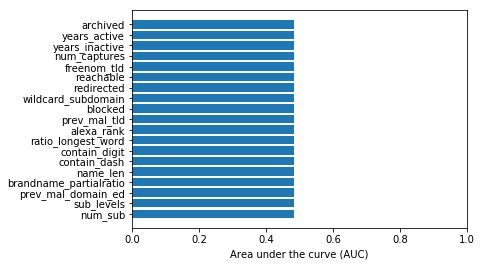

In [321]:
aucs = [x[0] for x in auc_feat_list]
feats = [x[1] for x in auc_feat_list]

fig, ax = plt.subplots()
plt.figure(figsize=(15,10))

# Example data
y_pos = np.arange(len(feats))

ax.barh(y_pos, aucs, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(feats)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Area under the curve (AUC)')
ax.set_xlim([0,1])
#ax.set_title('How fast do you want to go today?')

plt.show()

# Predict

In [390]:
datasets = set([d['dataset'] for d in data_predict])
print(datasets)
dataset_predict = ['comp-deltaphish','mal-future-apwg','mal-phishlabs', 'train_rest', 'val_rest']
compare_datasets=dict()
compare_datasets['acc'] = []
compare_datasets['err'] = []
compare_names = []
for dataset in dataset_predict:
    clf_datasets_acc = []
    clf_datasets_err = []
    clf_names = []
    for name, clf in zip(names, classifiers):
        clf.fit(Xtrain, ytrain)
        
        # get X and y for specific datasets
        if dataset == 'train_rest':
            Xpredict = Xtest
            ypredict = ytest
        elif dataset == 'val_rest':
            Xpredict = Xvaltestb
            ypredict = yvaltestb
        else:
            Xpredict = np.array([d['feat'] for d in data_predict if d['dataset'] in dataset])
            ypredict = np.array([d['target'] for d in data_predict if d['dataset'] in dataset])
        
        # transform (handle nan and normalize)
        Xpredict = imp.transform(Xpredict)
        Xpredict = scaler.transform(Xpredict)
        
        # calibrate
        Xpredict = applyIsoFunction(Xpredict, ypredict, iso_functions)
        
        # predict
        ypredict_pred = clf.predict(Xpredict)
        #tn, fp, fn, tp = confusion_matrix(ypredict, Xpredict_pred, labels=[-1,1]).ravel()
        
        # evaluation criteria
        acc = accuracy_score(ypredict, ypredict_pred)
        err = 1-acc
        #avg_acc = (tp+tn)/2
        
        # add avg_acc and corresponding name label
        clf_datasets_acc.append(acc)
        clf_datasets_err.append(err)
        clf_name = '-'.join([name, dataset])
        print(clf_name)
        clf_names.append(clf_name)
    
    # add dataset results for specific clf
    compare_datasets['acc'].append(clf_datasets_acc)
    compare_datasets['err'].append(clf_datasets_err)
    compare_names.append(clf_names)

{'mal-future-apwg', 'comp-deltaphish', 'comp-phishlabs', 'mal-apwg', 'mal-phishlabs', 'unlabeled-apwg'}
KNeighbors-comp-deltaphish
NeuralNetwork-comp-deltaphish
DecisionTree-comp-deltaphish
RandomForest-comp-deltaphish
Dummy-comp-deltaphish
KNeighbors-mal-future-apwg
NeuralNetwork-mal-future-apwg
DecisionTree-mal-future-apwg
RandomForest-mal-future-apwg
Dummy-mal-future-apwg
KNeighbors-mal-phishlabs
NeuralNetwork-mal-phishlabs
DecisionTree-mal-phishlabs
RandomForest-mal-phishlabs
Dummy-mal-phishlabs
KNeighbors-train_rest
NeuralNetwork-train_rest
DecisionTree-train_rest
RandomForest-train_rest
Dummy-train_rest
KNeighbors-val_rest
NeuralNetwork-val_rest
DecisionTree-val_rest
RandomForest-val_rest
Dummy-val_rest


In [391]:
pprint(compare_datasets['acc'])

[[0.7416545718432511,
  0.737300435413643,
  0.9201741654571843,
  0.9361393323657474,
  0.4934687953555878],
 [0.8471337579617835,
  0.7579617834394905,
  0.9171974522292994,
  0.9235668789808917,
  0.5222929936305732],
 [0.8302425106990015,
  0.7835235378031383,
  0.8248930099857347,
  0.8088445078459344,
  0.5035663338088445],
 [1.0, 1.0, 0.9493223335297584, 0.9723040659988215, 0.493223335297584],
 [0.7471264367816092,
  0.7126436781609196,
  0.7931034482758621,
  0.7988505747126436,
  0.5287356321839081]]


# Friedman test and Nemenyi CD

In [395]:
# compare samples
stat, p = friedmanchisquare(compare_datasets['acc'][0], compare_datasets['acc'][1], compare_datasets['acc'][2], compare_datasets['acc'][3], compare_datasets['acc'][4])
#stat, p = friedmanchisquare(compare_datasets[0], compare_datasets[2], compare_datasets[4])

print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=5.600, p=0.231
Same distributions (fail to reject H0)


In [139]:
from numpy.random import seed
from numpy.random import randn
# seed the random number generator
seed(1)
# generate three independent samples
data1 = 5 * randn(100) + 50
data2 = 5 * randn(100) + 50
data3 = 5 * randn(100) + 52
# compare samples
stat, p = friedmanchisquare(data1, data2, data3)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=9.360, p=0.009
Different distributions (reject H0)


In [393]:
ranks = []
for comp in compare_datasets['err']:
    rank = rankdata(comp)
    ranks.append(rank)
print(ranks)
avranks = np.mean(ranks, axis=0)
print(avranks)

[array([3., 4., 2., 1., 5.]), array([3., 4., 2., 1., 5.]), array([1., 4., 2., 3., 5.]), array([1.5, 1.5, 4. , 3. , 5. ]), array([3., 4., 2., 1., 5.])]
[2.3 3.5 2.4 1.8 5. ]


5


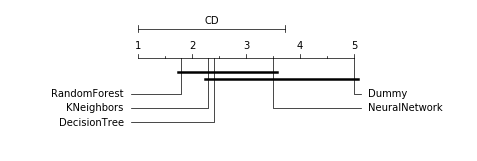

In [394]:
#names = ["first", "third", "second", "fourth" ]
#avranks =  [1.9, 3.2, 2.8, 3.3 ]
num_datasets = len(dataset_predict)
print(num_datasets)
cd = compute_CD(avranks, num_datasets)
graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
plt.show()

# Model persistence

In [17]:
from joblib import dump, load
modelname = 'apwg'
filename = './model/'+modelname+'_scaler.joblib'
dump(scaler, filename)

['finalized_scaler.joblib']

In [21]:
filename = './model/'+modelname+'_imputer.joblib'
dump(imp, filename)

['finalized_imputer.joblib']

In [14]:
clf = classifiers[3]
clf.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [20]:
#from joblib import dump, load
filename = './model/'+modelname+'_model.joblib'
dump(clf, filename)
#pickle.dump(clf, 'mlp.joblib') 

['finalized_model.joblib']